In [138]:
#---standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil # only applicable to moving the files
import os
#-----for working with audio files (need to conda install these)
import librosa 
import librosa.display

### Read Me

This script bypasses the need to work with a csv for the audio portions. The csv seems to corrupt the output of librosa, so this is the easiest way to preserve librosa output 

In [87]:
def undersample_data(filename):
    ## given a csv file, balances the dataset by undersampling method
    ## Split Dataset into Aves and Carnivora
    sdf = pd.read_csv(filename)
    aves = sdf[sdf['group']=='Aves']
    aves_grouped = aves.groupby(['Common Name']).size().reset_index(name='counts')
    carnivora = sdf[sdf['group']=='Carnivora']
    carn_grouped = carnivora.groupby(['Common Name']).size().reset_index(name='counts')
    #reduce datasets to only species with between 20 & 80 files
    aves_short = aves_grouped[aves_grouped['counts'].between(20,80)]
    carn_short = carn_grouped[carn_grouped['counts'].between(20,80)]
    ##randomly sample species list, to get a subset of aves, so the length is closer to len(carn)
    aves_short_sampled = aves_short.sample(16)
    aves_short_sampled.groupby(['Common Name']).size().reset_index(name='counts')
    #create the final sampled aves and carn lists from original split lists 
    aves_df = aves[aves['Common Name'].isin(aves_short_sampled['Common Name'])]
    carn_df = carnivora[carnivora['Common Name'].isin(carn_short['Common Name'])]
    #combine the split lists back into one list 
    undersampled_df = pd.concat([aves_df,carn_df])
    return undersampled_df

## These were used to pull only the relevant wav files for our ML portion, only works will full set of wav files

In [88]:
#lst = undersample_data('spectrogram2.csv')
#display(len(lst['gbifID']))
#id_array = lst['gbifID'].to_list()

In [89]:
#----saves undersampled data to csv (these entries correspond to the files in the zipped wavsubset folder)
#lst[['gbifID', 'type','format','URL','group','Common Name', 'Scientific Name', 'Type', 'id']].to_csv('undersampled_data.csv')

In [90]:
#for the sampled list, copy the relevant wav files to share so script can be run
srcdir = '/Users/katel/Documents/output/output/wavs'
dstdir = '/Users/katel/Documents/output/output/wavsubset'
def copy_relevant_wav_files(srcdir, dstdir):
    #used to get the relevant wav files for the next section 
    for filename in os.scandir(srcdir):
        if not filename.is_file():
            continue

        gid = os.path.basename(filename.path.split(".")[0])
        if int(gid) not in id_array:
            continue

        src = filename.path
        dst =  f'{dstdir}/{gid}.wav'

        shutil.copyfile(src, dst)

## Functions Used

Below is several functions used to create spectrograms, there is a function at the end ('create_spectro_df') that should be all you need to create a pandas df containing spectrograms directly from the wav files. 

In [91]:
#------use to output mfcc
def convert_wav_to_mfcc(filename):
    """
    #helper function called in output_mfcc
    #loads and decodes audio as time series
    #(y = 1d np array, sr = sampling rate, #samples per second of audio)
    #default resample = 22050 Hz, changed to 44100
    """
    y, sr = librosa.load(filename, sr=44100)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    zero_crossings_count = librosa.zero_crossings(y, pad=False)
    zero_crossings = sum(zero_crossings_count)
    return mfcc, y, sr, zero_crossings

def output_mfcc(directory):
    #---takes directory of wav files to convert
    #---Stores MFCC outputs in lists 
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst = []
    mfcc_lst = []
    zero_crossings_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 200 == 0:
            print(i, end=",")
        if filename.is_file():
            mfcc, y, sr, zero_crossings = convert_wav_to_mfcc(filename.path)
            gid = os.path.basename(filename.path.split(".")[0])
            good_id_lst.append(gid)
            y_lst.append(y)
            sr_lst.append(sr)
            mfcc_lst.append(mfcc)
            zero_crossings_lst.append(zero_crossings)
    return good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst

In [92]:
#---use to output melspectrogram in decibels
def convert_wav_to_melspectro(filename):
    #helper function called in output_melspectro
    y, sr = librosa.load(filename, sr=44100)
    melspectro = librosa.feature.melspectrogram(y=y, sr=sr)
    melspectro_db = librosa.power_to_db(melspectro, ref=np.max)
    zero_crossings_count = librosa.zero_crossings(y, pad=False)
    zero_crossings = sum(zero_crossings_count)
    return melspectro_db, y, sr, zero_crossings

def output_melspectro(directory):
    #---takes directory of wav files to convert
    #---Stores melspectro outputs in lists 
    #initialize lists
    good_id_lst = []
    y_lst = []
    sr_lst = []
    melspectro_lst = []
    zero_crossings_lst = []

    # iterate over files in
    # that directory
    i = 0
    for filename in os.scandir(directory):
        i += 1
        if i % 200 == 0:
            print(i, end=",")
        if filename.is_file():
            melspectro_db, y, sr, zero_crossings = convert_wav_to_melspectro(filename.path)
            gid = os.path.basename(filename.path.split(".")[0])
            good_id_lst.append(gid)
            y_lst.append(y)
            sr_lst.append(sr)
            melspectro_lst.append(melspectro_db)
            zero_crossings_lst.append(zero_crossings)
    return good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst

In [93]:
#---use to turn mfcc or melspectro data into dataframe
def convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, spectrogram_lst, zero_crossings_lst):
    #takes outputs of output_melspectro or output_mfcc functions AND undersampled_data, returns dataframe
    #where spectrogram_lst = mfcc or melspectro list 
    final_id_lst = []
    for i in good_id_lst:
        fin = i.split(".")[0]
        final_id_lst.append(fin)
            
    spectro_dic = {'id':final_id_lst,'y':y_lst,'sr': sr_lst,'spectrogram': spectrogram_lst, 'zero_crossing':zero_crossings_lst}
    spectro_df = pd.DataFrame(spectro_dic)

    spectro_df['gbifID'] = spectro_df['id'].astype('int64')
    spectrogram_df = pd.merge(undersampled_df, spectro_df, on='gbifID', how="left")
    return spectrogram_df

In [94]:
def test_librosa(filepath):
    ##--test sample audio file to test librosa output 
    y, sr = librosa.load(filepath, sr=44100)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    print("Total MFCC features " + str(mfcc.shape[0]) + " for the total " + str(mfcc.shape[1]) + " frames." )
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')

In [95]:
def draw_spectrogram(spectrogram, sr):
    librosa.display.specshow(spectrogram, sr=sr, x_axis='time')

## Review Undersampled Data

Data is now close to balanced, there are approximately equal number of species and anywhere from 20-80 samples per species in each group

In [96]:
undersampled_df = pd.read_csv('undersampled_data.csv')
names = undersampled_df.groupby(['group','Type','Common Name']).size().reset_index(name='counts')
display(names)

,group,Type,Common Name,counts
0,Aves,Not Dangerous,Athene,20
1,Aves,Not Dangerous,Crested Lark,23
2,Aves,Not Dangerous,European Nightjar,34
3,Aves,Not Dangerous,Fieldfare,35
4,Aves,Not Dangerous,Firecrest,23
5,Aves,Not Dangerous,Grasshopper Warbler,38
6,Aves,Not Dangerous,Grey-Heades Woodpecker,42
7,Aves,Not Dangerous,Hill Myna,61
8,Aves,Not Dangerous,Mallard,45
9,Aves,Not Dangerous,Mistle Thrush,42


## Start Here!!

In [97]:
def create_spectro_df(directory, desired_type, undersampled_df):
    """
    directory = supply directory of .wav files from wavsubset.zip 
       Ex: directory  = '/Users/katel/Documents/output/output/wavsubset'
    desired_type = 'mfcc' or 'melspectro'
    undersampled_df = pd.read_csv('undersampled_data.csv') - above
    """
    if desired_type == 'mfcc':
        good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst = output_mfcc(directory)
        mfcc_df = convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, mfcc_lst, zero_crossings_lst)
        return mfcc_df
    elif desired_type == 'melspectro':
        good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst = output_melspectro(directory)
        melspectro_df = convert_to_df(undersampled_df, good_id_lst, y_lst, sr_lst, melspectro_lst, zero_crossings_lst)
        return melspectro_df
    else: 
        print("error, make sure you supplied correct input")
        
    

### Ensure you change directory of the next two cells to wherever 'wavsubset.zip' is stored (in unzipped form)

In [120]:
%%time
#---change directory to wherever you stored the 'wavsubset.zip' files 
mfcc_df = create_spectro_df(directory  = '/Users/flunc/FA22_Final Project/wavsubset', desired_type='mfcc', undersampled_df = undersampled_df)

200,400,600,800,1000,1200,Wall time: 11min 45s


In [16]:
%%time
#---change directory to wherever you stored the 'wavsubset.zip' files 
melspectro_df = create_spectro_df(directory  = '/Users/flunc/FA22_Final Project/wavsubset', desired_type='melspectro', undersampled_df = undersampled_df)

200,400,600,800,1000,1200,Wall time: 11min 44s


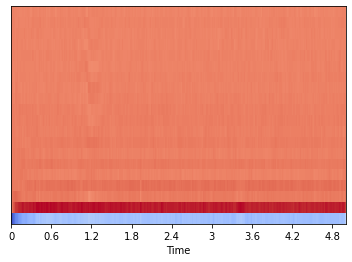

In [121]:
#test on one output for mfcc df
draw_spectrogram(mfcc_df['spectrogram'][0], mfcc_df['sr'][0])

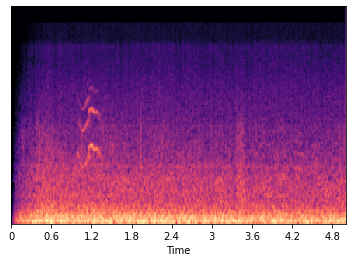

In [122]:
# test on one output for melspectro df
draw_spectrogram(melspectro_df['spectrogram'][0], melspectro_df['sr'][0])

In [123]:
display(mfcc_df.head())

,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-801.48914, -800.42334, -772.4419, -732.381,...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-595.9011, -593.62805, -566.94946, -539.8847...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,Not Dangerous,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-722.07367, -719.8397, -672.3625, -615.5229,...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,Not Dangerous,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-673.0887, -632.0292, -465.77396, -348.41882...",48782
4,332,1269848114,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cor...,Aves,Raven,Corvus corax,Not Dangerous,1269848114,1269848114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-669.52844, -669.0911, -610.478, -492.42038,...",29243


In [96]:
display(melspectro_df.head())

,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -80.0, -50.316353, -45.723316, -42.37...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,Not Dangerous,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -76.81369, -58.618816, -47.21679, -40...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,Not Dangerous,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -70.03779, -45.730125, -38.054024, -3...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,Not Dangerous,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -59.98756, -39.351402, -28.339111, -2...",48782
4,332,1269848114,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Cor...,Aves,Raven,Corvus corax,Not Dangerous,1269848114,1269848114,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -77.60765, -51.018013, -43.877937, -4...",29243


## Modeling the data using One-Class SVM (Using the MFCC)
Note: changing the Type to be a binary component

Class Distribution:
    
    Not Dangerous    0     686     (51.7%)
    Dangerous        1     640     (48.3%)

In [124]:
mfcc_df["Type"] = [0 if mfcc_df.iloc[i].loc["group"] == "Aves" else 1 for i in range(0, mfcc_df.shape[0])]
print("Not Dangerous Count: ", mfcc_df["Type"].where(mfcc_df["Type"] == 0).count())
print("Dangerous Count: ", mfcc_df["Type"].where(mfcc_df["Type"] == 1).count())
print("Shape: ", mfcc_df.shape)
display(mfcc_df.iloc[:4,:])

Not Dangerous Count:  686
Dangerous Count:  640
Shape:  (1326, 15)


,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,0,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-801.48914, -800.42334, -772.4419, -732.381,...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,0,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-595.9011, -593.62805, -566.94946, -539.8847...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,0,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-722.07367, -719.8397, -672.3625, -615.5229,...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,0,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-673.0887, -632.0292, -465.77396, -348.41882...",48782


In [255]:
## ----- Standard Imports for modelling ----- ##
from sklearn.utils import shuffle
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Remove data points where shape is not equal to (20,431)
to_drop = []
for i in range(0, mfcc_df.shape[0]):
    if mfcc_df.iloc[i].loc["spectrogram"].shape != (20,431):
        to_drop.append(i)

data = mfcc_df.copy()
data.drop(to_drop, inplace=True)

# Reduce spectrograms to 1D array
specs = []
for i in range(0, data.shape[0]):
    specs.append(data.iloc[i,13].reshape(20*431))

## Split to features and labels
## Features are column 13
## Labels are column 8
data_X = np.asarray(specs)
print("Original: ", data_X.shape)
data_Y = data.iloc[:,8]

## Perform PCA on the data
pca = PCA(n_components = 4)
PCA_X = pca.fit_transform(data_X)

print("PCA: ", PCA_X.shape)

Original:  (1248, 8620)
PCA:  (1248, 4)


In [256]:
## Randomly shuffle data and partition to train (70%) and test (30%)
split_amt = round(data.shape[0]*.70)

d_X, d_Y = shuffle(PCA_X, data_Y)
train_X = PCA_X[:split_amt]
train_Y = data_Y.iloc[:split_amt]
test_X = PCA_X[split_amt:]
test_Y = data_Y.iloc[split_amt:]

# Extract the "Not Dangerous" data points from training
nd = train_Y[train_Y==0].index
train_X = train_X[nd]
train_Y = train_Y[nd]

## Build one-class SVM model with RBF kernel using default gamma
svm = OneClassSVM().fit(train_X,train_Y)
# inliers (1), outliers (-1)
svm_pred = svm.predict(test_X)
svm_pred[svm_pred == 1] = 0
svm_pred[svm_pred == -1] = 1

print("Accuracy: ", round(accuracy_score(test_Y, svm_pred)*100, 2))

Accuracy:  59.09


In [260]:
## Testing out optimal gamma value for One-Class SVM
gamma = np.arange(0.0000001,0.00001 , 0.0000001)
svm_accs = []
for g in gamma:
    svm = OneClassSVM(gamma=g).fit(train_X,train_Y)
    svm_pred = svm.predict(test_X)
    svm_pred[svm_pred == 1] = 0
    svm_pred[svm_pred == -1] = 1
    svm_accs.append(accuracy_score(test_Y, svm_pred))

## Maximum accuracy 
max_mfcc = np.argmax(svm_accs)
print("Maximum accuracy achieved using gamma ", gamma[max_mfcc], ": ", svm_accs[max_mfcc])


Maximum accuracy achieved using gamma  9.800000000000001e-06 :  0.9197860962566845


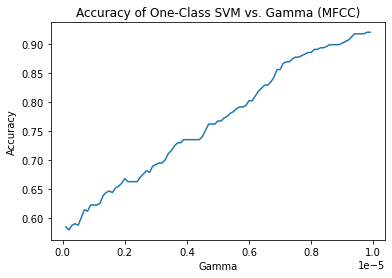

In [262]:
## Plotting Accuracy score with respect to gamma value
fig1, ax1 = plt.subplots()
plt.plot(gamma, svm_accs)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("Accuracy of One-Class SVM vs. Gamma (MFCC)")
plt.show()

## Modeling the data using One-Class SVM (Using the MelSpectro)
Note: changing the Type to be a binary component

Class Distribution:
    
    Not Dangerous    0     686     (51.7%)
    Dangerous        1     640     (48.3%)

In [213]:
melspectro_df["Type"] = [0 if melspectro_df.iloc[i].loc["group"] == "Aves" else 1 for i in range(0, melspectro_df.shape[0])]
print("Not Dangerous Count: ", melspectro_df["Type"].where(melspectro_df["Type"] == 0).count())
print("Dangerous Count: ", melspectro_df["Type"].where(melspectro_df["Type"] == 1).count())
print("Shape: ", melspectro_df.shape)
display(melspectro_df.iloc[:4,:])

Not Dangerous Count:  686
Dangerous Count:  640
Shape:  (1326, 15)


,Unnamed: 0,gbifID,type,format,URL,group,Common Name,Scientific Name,Type,id_x,id_y,y,sr,spectrogram,zero_crossing
0,252,1269848194,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,0,1269848194,1269848194,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -80.0, -50.316353, -45.723316, -42.37...",2203
1,253,1269848193,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Str...,Aves,Tawny Owl,Strix aluco,0,1269848193,1269848193,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -76.81369, -58.618816, -47.21679, -40...",2519
2,264,1269848182,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Ral...,Aves,Water Rail,Rallus aquaticus,0,1269848182,1269848182,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -70.03779, -45.730125, -38.054024, -3...",13933
3,292,1269848154,Sound,audio/mpeg,http://www.tierstimmenarchiv.de/recordings/Loc...,Aves,Grasshopper Warbler,Locustella naevia,0,1269848154,1269848154,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,"[[-80.0, -59.98756, -39.351402, -28.339111, -2...",48782


In [263]:
# Remove data points where shape is not equal to (128,431)
to_drop = []
for i in range(0, melspectro_df.shape[0]):
    if melspectro_df.iloc[i].loc["spectrogram"].shape != (128,431):
        to_drop.append(i)

mel = melspectro_df.copy()
mel.drop(to_drop, inplace=True)

# Reduce spectrograms to 1D array
melspecs = []
for i in range(0, mel.shape[0]):
    melspecs.append(mel.iloc[i,13].reshape(128*431))

## Split to features and labels
## Features are column 13
## Labels are column 8
mel_X = np.asarray(melspecs)
print("Original: ", mel_X.shape)
mel_Y = mel.iloc[:,8]

## Perform PCA on the data
pca2 = PCA(n_components = 4)
PCAmel_X = pca2.fit_transform(mel_X)

print("PCA: ", PCAmel_X.shape)

Original:  (1248, 55168)
PCA:  (1248, 4)


In [265]:
## Randomly shuffle data and partition to train (70%) and test (30%)
split_amt = round(mel.shape[0]*.70)
    
meltrain_X = PCAmel_X[:split_amt]
meltrain_Y = mel_Y.iloc[:split_amt]
meltest_X = PCAmel_X[split_amt:]
meltest_Y = mel_Y.iloc[split_amt:]

# Extract the "Not Dangerous" data points from training
nd = meltrain_Y[meltrain_Y==0].index
meltrain_X = meltrain_X[nd]
meltrain_Y = meltrain_Y[nd]

## Build one-class SVM model with RBF kernel using default gamma
melsvm = OneClassSVM().fit(meltrain_X, meltrain_Y)
# inliers (1), outliers (-1)
melsvm_pred = melsvm.predict(meltest_X)
melsvm_pred[melsvm_pred == 1] = 0
melsvm_pred[melsvm_pred == -1] = 1

print("Accuracy: ", round(accuracy_score(meltest_Y, melsvm_pred)*100, 2))

Accuracy:  58.29


In [266]:
## Testing out optimal gamma value for One-Class SVM
gamma = np.arange(0.0000001,0.00001 , 0.0000001)
melsvm_accs = []
for g in gamma:
    melsvm = OneClassSVM(gamma=g).fit(meltrain_X,meltrain_Y)
    melsvm_pred = melsvm.predict(meltest_X)
    melsvm_pred[melsvm_pred == 1] = 0
    melsvm_pred[melsvm_pred == -1] = 1
    melsvm_accs.append(accuracy_score(test_Y, melsvm_pred))

## Maximum accuracy 
max_mel = np.argmax(melsvm_accs)
print("Maximum accuracy achieved using gamma ", gamma[max_mel], ": ", melsvm_accs[max_mel])

Maximum accuracy achieved using gamma  9.9e-06 :  0.9331550802139037


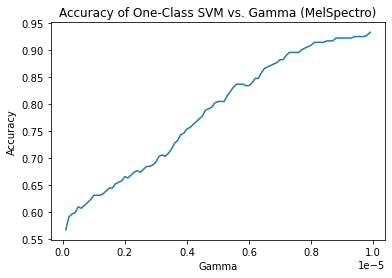

In [267]:
## Plotting Accuracy score with respect to gamma value
fig2, ax2 = plt.subplots()
plt.plot(gamma, melsvm_accs)
plt.xlabel("Gamma")
plt.ylabel("Accuracy")
plt.title("Accuracy of One-Class SVM vs. Gamma (MelSpectro)")
plt.show()